In [1]:
#import allel
#from os import path
#import sys
#data_dir = '/home/hsher/1000Genomes'
#chr22 = 'ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'
#tabix = '/usr/local/bin/tabix'
#info = allel.read_vcf(path.join(data_dir, chr22),log=sys.stdout)


# to genotype array
#gt = allel.GenotypeArray(info['calldata/GT'], dtype = 'i1')
#gt = gt.to_n_alt(fill = -1)


In [2]:
#import numpy as np; save in case it does not work
#np.save('/home/hsher/1000Genomes/chr22_100000.npy',gt[:100000,:])
#np.savez('/home/hsher/1000Genomes/chr22.npz', gt)

In [3]:
#np.save('/home/hsher/1000Genomes/sample.npy', info['samples'])

[Based on this tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
import allel
from os import path
import sys

# import preprocessed data
data_dir = '/home/hsher/1000Genomes'
gt = np.load('/home/hsher/1000Genomes/chr22_100000.npy')
sample = np.load('/home/hsher/1000Genomes/sample.npy', allow_pickle = True)

# read 
sample_info = pd.read_excel(path.join(data_dir, '20130606_sample_info.xlsx'), index_col = 0)

In [5]:
# 100000 allel is still too many
gt.shape

(100000, 2504)

In [6]:
# select popular snp only
gt_subset = gt[gt.sum(axis = 1)>100,:]

In [7]:
gt_subset.shape

(15275, 2504)

In [8]:
# to use scanpy, everything has to go into AnnData, see https://anndata.readthedocs.io/en/stable/anndata.AnnData.html
adata = AnnData(X = gt_subset.T, obs = sample_info.loc[sample])

In [9]:
adata

AnnData object with n_obs × n_vars = 2504 × 15275
    obs: 'Family ID', 'Population', 'Population Description', 'Gender', 'Relationship', 'Unexpected Parent/Child ', 'Non Paternity', 'Siblings', 'Grandparents', 'Avuncular', 'Half Siblings', 'Unknown Second Order', 'Third Order', 'Other Comments'

In [10]:
# just follow scanpy preprocessing pipeline, may need modification (maybe human pop don't need normalization...etc)
adata.X = adata.X.astype('float64') 
sc.pp.recipe_zheng17(adata)

In [11]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=2)
#pca.fit(adata.X)
#X_transform = pca.transform(adata.X)

In [12]:
# every other low dimensional visualization is based on PCA; pca is already slow for 15000 snps
sc.tl.pca(adata)

... storing 'Family ID' as categorical
... storing 'Population' as categorical
... storing 'Population Description' as categorical
... storing 'Gender' as categorical
... storing 'Relationship' as categorical
... storing 'Unexpected Parent/Child ' as categorical
... storing 'Non Paternity' as categorical
... storing 'Siblings' as categorical
... storing 'Grandparents' as categorical
... storing 'Avuncular' as categorical
... storing 'Half Siblings' as categorical
... storing 'Unknown Second Order' as categorical
... storing 'Third Order' as categorical


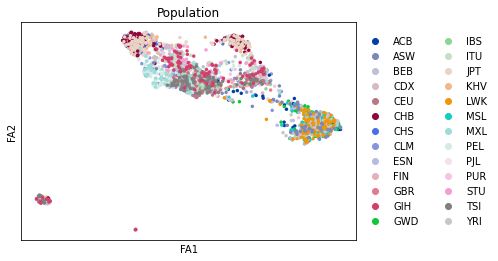

In [14]:
# nearest neighbor graph is the basis of umap
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color = 'Population')


In [15]:
# customize color
pop_to_color = {"ACB": "blue", "ASW": "mediumblue", "BEB": "darkblue", 
                "CDX": "green", "CHB": "forestgreen", "CHS": "limegreen", "JPT": "seagreen",
                 "CEU": "yellow", "ESN": "gold", "FIN": "goldenrod", "GBR": "burlywood", "IBS": "tan", "ITU": "khaki", "TSI": "darkkhaki",
                "CLM": "purple", "MXL": "darkviolet", "PEL": "darkorchid", "PJL": "mediumorchid", "PUR": "violet", "STU": "blueviolet",
                "GIH": "orange", "GWD": "tomato",
                "KHV": "red", "LWK": "darkred","MSL": "indianred", "YRI": "firebrick",
                "None": "gray"    
               }
adata.uns['Population_colors'] = adata.obs['Population'].cat.categories.map(pop_to_color)

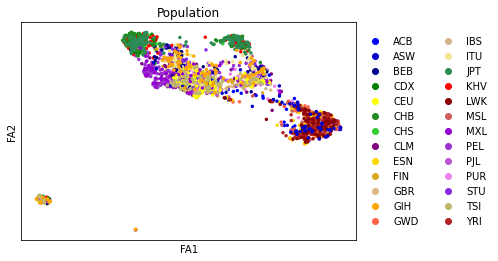

In [16]:
sc.pl.draw_graph(adata, color = 'Population')

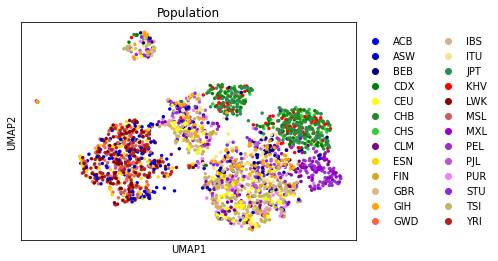

In [17]:
# do umap
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Population'])

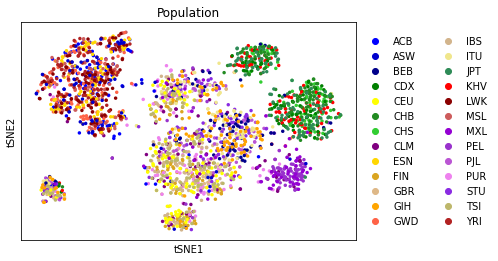

In [18]:
# to tsne
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=['Population'])

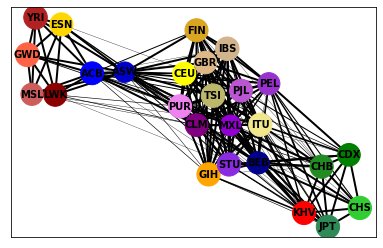

In [19]:
# do PAGA
sc.tl.paga(adata, groups='Population')
sc.pl.paga(adata, color=['Population'], max_edge_width = 2, node_size_scale= 4)

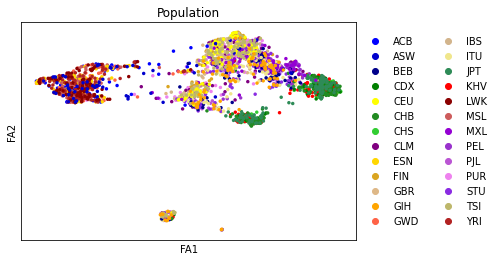

In [20]:
# use paga to initialize force directed layout
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['Population'])

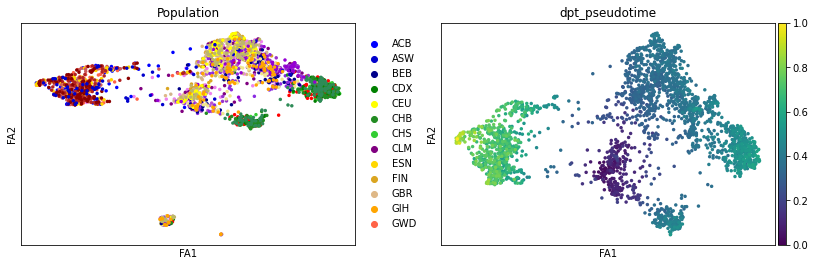

In [21]:
# assume CEU as the root of all human, compute pseudotime; super SLOW
adata.uns['iroot'] = np.flatnonzero(adata.obs['Population']  == 'CEU')[0]
sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=['Population', 'dpt_pseudotime'])